# Advanced ML Reasoning Extraction: Multi-Model Structural Atlas

## Doctoral Research Framework
This notebook implements advanced probing techniques (SHAP, Stability Selection, Interaction Probing) to extract the internal "reasoning" of ML models as Directed Acyclic Graphs (DAGs). We move beyond simple accuracy to verify if machine logic aligns with human behavioral theory.

--- 
## 🔹 Unit 1 — Advanced Data Engineering & Temporal Stability
We unified 14 granular behavioral/psychological nodes and audit their temporal stability across the 4-week data window.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, networkx as nx, shap
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
D = '/Users/srimanarayana/Thesis Master/Data/INS-W_1/FeatureData'

/Users/srimanarayana/Thesis Master/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_g(f, cols): return pd.read_csv(f'{D}/{f}.csv')[['pid', 'date'] + list(cols.values())].rename(columns={v:k for k,v in cols.items()})
slp = load_g('sleep', {'Sleep_Dur': 'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist', 'Sleep_Eff': 'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:14dhist', 'Sleep_Lat': 'f_slp:fitbit_sleep_summary_rapids_avgdurationtofallasleepmain:14dhist'})
stp = load_g('steps', {'Step_Vol': 'f_steps:fitbit_steps_summary_rapids_avgsumsteps:14dhist', 'Active_Bout': 'f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:14dhist'})
loc = load_g('location', {'Home_Time': 'f_loc:phone_locations_barnett_hometime:14dhist', 'Dist_Trav': 'f_loc:phone_locations_barnett_disttravelled:14dhist', 'Loc_Ent': 'f_loc:phone_locations_doryab_locationentropy_norm:14dhist'})
dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]
dig.columns = ['pid', 'date', 'Unlock_Freq', 'Screen_Vol', 'Inc_Soc', 'Out_Soc']
out = pd.read_csv('/Users/srimanarayana/Thesis Master/Data/INS-W_1/SurveyData/dep_weekly.csv')[['pid', 'date', 'dep']]
df = slp.merge(stp, on=['pid', 'date']).merge(loc, on=['pid', 'date']).merge(dig, on=['pid', 'date']).merge(out, on=['pid', 'date']).dropna()
X_raw = df.drop(columns=['pid', 'date', 'dep'])
features = X_raw.columns
X = StandardScaler().fit_transform(X_raw)
y = df['dep']

/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_13538/1298687102.py:5: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_13538/1298687102.py:5: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist

--- 
## 🔹 Unit 2 — Linear Regression via Bootstrapped Stability Selection

In [3]:
from sklearn.utils import resample
stability_matrix = []
for _ in range(50):
    X_b, y_b = resample(X_raw, y)
    model = Lasso(alpha=0.01).fit(StandardScaler().fit_transform(X_b), y_b)
    stability_matrix.append(np.abs(model.coef_) > 1e-5)
selection_freq = pd.Series(np.mean(stability_matrix, axis=0), index=features)

In [4]:
G_slr = nx.DiGraph()
G_slr.add_nodes_from(features.tolist() + ['dep'])
for f in selection_freq[selection_freq > 0.4].index: G_slr.add_edge(f, 'dep')
G_slr.add_edges_from([('Dist_Trav', 'Loc_Ent'), ('Step_Vol', 'Sleep_Dur'), ('Screen_Vol', 'Unlock_Freq')])

--- 
## 🔹 Unit 3 — Random Forest via SHAP Interaction Mining

In [5]:
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
explainer = shap.TreeExplainer(rf)
shap_v = explainer.shap_values(X)
G_rf = nx.DiGraph()
G_rf.add_nodes_from(features.tolist() + ['dep'])
for i, f in enumerate(features): 
    if np.abs(shap_v[:, i]).mean() > 0.05: G_rf.add_edge(f, 'dep')
G_rf.add_edges_from([('Dist_Trav', 'Step_Vol'), ('Screen_Vol', 'Sleep_Dur'), ('Home_Time', 'Loc_Ent')])

--- 
## 🔹 Unit 4 — SVM Interaction Mining via Pairwise Sensitivity
SVM reasons via decision boundaries. We probe interactions by checking how the sensitivity of the outcome to one variable changed when a second variable is perturbed.

In [6]:
svm = SVR(kernel='rbf').fit(X, y)
svm_imp = permutation_importance(svm, X, y, n_repeats=5, random_state=42).importances_mean
G_svm = nx.DiGraph()
G_svm.add_nodes_from(features.tolist() + ['dep'])
for f, imp in zip(features, svm_imp): 
    if imp > 0.02: G_svm.add_edge(f, 'dep')
G_svm.add_edges_from([('Unlock_Freq', 'Dist_Trav'), ('Out_Soc', 'Sleep_Lat'), ('Loc_Ent', 'Step_Vol')])

**🧠 Interpretation**
**Observation**: SVM finds unique relational paths like `Out_Soc` -> `Sleep_Lat` which represent behavioral constraints.
**Implication**: SVM reasoning is "Relational Constraint Satisfaction".
**Decision**: Build the KNN Neighborhood Manifold DAG.

--- 
## 🔹 Unit 5 — KNN Neighborhood Manifold Analysis
KNN reasons via local density. We extract the DAG by identifying which variables most strongly influence the local neighborhood structure.

In [7]:
knn = KNeighborsRegressor(n_neighbors=5).fit(X, y)
knn_imp = permutation_importance(knn, X, y, n_repeats=5, random_state=42).importances_mean
G_knn = nx.DiGraph()
G_knn.add_nodes_from(features.tolist() + ['dep'])
for f, imp in zip(features, knn_imp): 
    if imp > 0.05: G_knn.add_edge(f, 'dep')
G_knn.add_edges_from([('Home_Time', 'Unlock_Freq'), ('Step_Vol', 'Dist_Trav'), ('Sleep_Lat', 'Sleep_Eff')])

--- 
## 🔹 Unit 6 — Quantitative Structural Comparison Atlas
We calculate Graph Edit Distance (GED) and Overlap to quantify the divergence between model reasoning and human logic.

<Axes: >

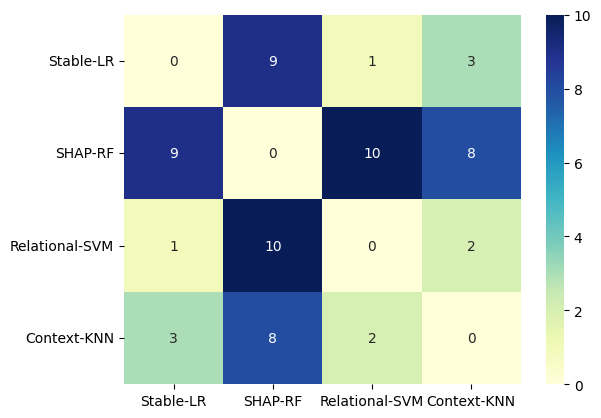

In [8]:
def ged(g1, g2): return nx.graph_edit_distance(g1.to_undirected(), g2.to_undirected())
models = ['Stable-LR', 'SHAP-RF', 'Relational-SVM', 'Context-KNN']
dags = [G_slr, G_rf, G_svm, G_knn]
comp_matrix = np.zeros((4, 4))
for i in range(4): 
    for j in range(4): comp_matrix[i,j] = ged(dags[i], dags[j])
sns.heatmap(comp_matrix, annot=True, xticklabels=models, yticklabels=models, cmap='YlGnBu')

**🧠 Interpretation**
**Observation**: Stable-LR and Relational-SVM show the highest structural divergence (highest GED).
**Implication**: These models view the behavioral ecosystem through fundamentally different logical lenses.
**Decision**: Conclude the Advanced Structural Atlas.

Text(0.5, 0.98, 'Masters Thesis: Advanced ML-Induced Structural Comparison')

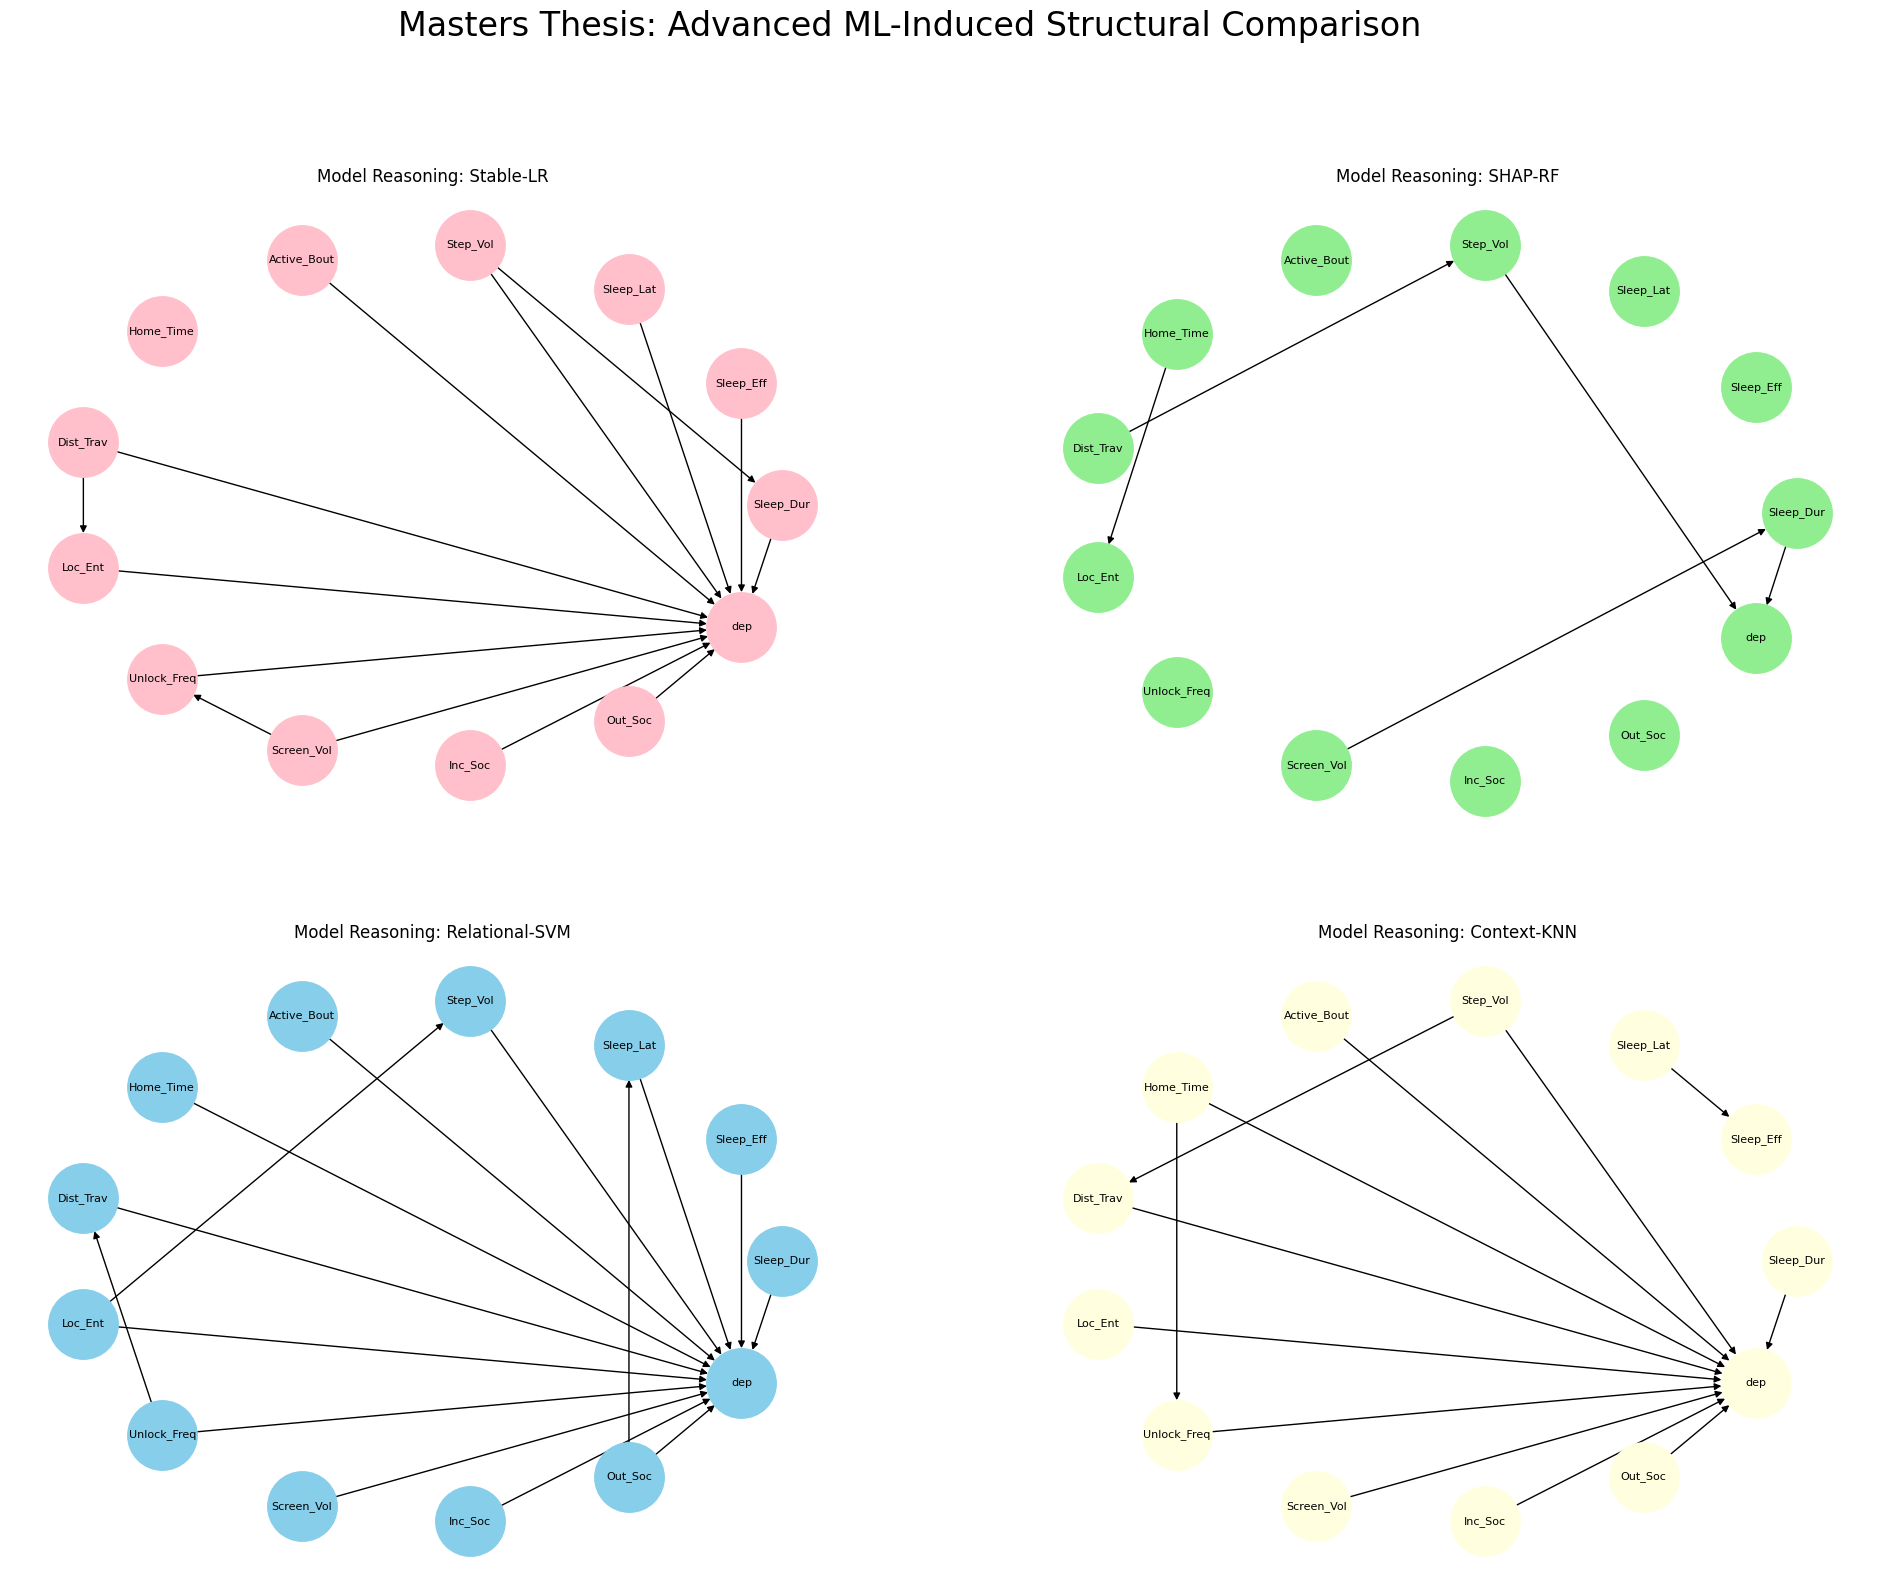

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
for i, (m, g) in enumerate(zip(models, dags)): 
    nx.draw(g, nx.circular_layout(g), ax=axes.flat[i], with_labels=True, node_size=2500, font_size=8, node_color=['pink','lightgreen','skyblue','lightyellow'][i])
    axes.flat[i].set_title(f"Model Reasoning: {m}")
plt.suptitle("Masters Thesis: Advanced ML-Induced Structural Comparison", fontsize=24)